# 1. Instalación

In [1]:
%pip install gym==0.17.3
%pip install numpy==1.23.5
# %pip install numpy==1.24.3
%pip install git+https://github.com/Kojoley/atari-py.git
%pip install keras-rl2==1.0.5
%pip install tensorflow==2.12.1

  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.4.38 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
jax 0.4.38 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
blosc2 3.5.0 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
nibabel 5.3.2 requires typing-extensions>=4.6; python_version < "3.13", but you have typing-extensions 4.5.0 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.


  Cloning https://github.com/Kojoley/atari-py.git to /tmp/pip-req-build-zm3gah5s
  Running command git clone --filter=blob:none --quiet https://github.com/Kojoley/atari-py.git /tmp/pip-req-build-zm3gah5s
  Resolved https://github.com/Kojoley/atari-py.git to commit 86a1e05c0a95e9e6233c3a413521fdb34ca8a089
  Preparing metadata (setup.py) ... done
  Using cached numpy-1.24.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.24.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blosc2 3.5.0 requires numpy>=1.26, but you have numpy 1.24.3 which is incompatible.
nibabel 5.3.2 requires typing-extensions>=4

In [17]:
import gym
import numpy as np

from keras import Model

import tensorflow as tf
from tensorflow.keras import layers, Model

import matplotlib.pyplot as plt

# 2. Implementación VAE 1 (este es el que se usa en la solución final)

## 2.1 Inicialización entorno

In [3]:
INPUT_SHAPE = (84, 84)
WINDOW_LENGTH = 4

env_name = 'SpaceInvaders-v0'
env = gym.make(env_name)


np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

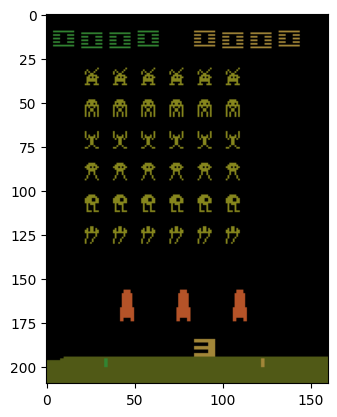

In [4]:
# Iniciar simulación
obs = env.reset()
plt.imshow(obs)
plt.show()

## 2.2 Generar observaciones


In [5]:
obs = env.reset()
done = False

tipo_accion = [
    np.random.randint(nb_actions, size=5000),
    np.concatenate((np.full((45), 2, dtype=int), np.random.randint(nb_actions, size=5000)), axis=0),
    np.concatenate((np.full((50), 2, dtype=int), np.random.randint(nb_actions, size=5000)), axis=0),
    np.concatenate((np.full((55), 2, dtype=int), np.random.randint(nb_actions, size=5000)), axis=0),
    np.concatenate((np.full((60), 2, dtype=int), np.random.randint(nb_actions, size=5000)), axis=0),
    np.concatenate((np.full((65), 2, dtype=int), np.random.randint(nb_actions, size=5000)), axis=0),
    np.concatenate((np.full((70), 2, dtype=int), np.random.randint(nb_actions, size=5000)), axis=0),
    np.concatenate((np.full((75), 2, dtype=int), np.random.randint(nb_actions, size=5000)), axis=0),
    np.concatenate((np.full((80), 2, dtype=int), np.random.randint(nb_actions, size=5000)), axis=0),
    np.concatenate((np.full((85), 2, dtype=int), np.random.randint(nb_actions, size=5000)), axis=0),
    np.concatenate((np.full((90), 2, dtype=int), np.random.randint(nb_actions, size=5000)), axis=0),
    np.concatenate((np.full((95), 2, dtype=int), np.random.randint(nb_actions, size=5000)), axis=0),
    np.concatenate((np.full((100), 2, dtype=int), np.random.randint(nb_actions, size=5000)), axis=0)
]

lista_obs = []

for tipo in tipo_accion:
  for accion in tipo:
    new_obs, reward, done, info = env.step(accion)

    lista_obs.append(new_obs)

    if done == True:
      obs = env.reset()
      break

print('Observation list size:', len(lista_obs))

Observation list size: 8236


### 2.2.1 Generar video

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

img = [] # some array of images
frames = [] # for storing the generated images
fig = plt.figure()
plt.axis('off')
for i in range(len(lista_obs)):
    frames.append([plt.imshow(lista_obs[i], cmap=cm.Greys_r,animated=True)])

ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=1000)
ani.save('movie.mp4')

<IPython.core.display.Javascript object>

## 2.3 Generar dataset

In [29]:
def preprocess_img(images):
  images = images.astype('float32') / 255

  images = tf.image.rgb_to_grayscale(images)

  images = tf.image.resize(images, [84, 84])

  return images

preprocessed_images = preprocess_img(np.array(lista_obs))

print(preprocessed_images.shape)

(8236, 84, 84, 1)


In [28]:
dataset = tf.data.Dataset.from_tensor_slices(preprocessed_images)
dataset = dataset.shuffle(buffer_size = 1000).batch(64).prefetch(tf.data.AUTOTUNE)

## 2.4 Definición modelo

In [10]:
LATENT_DIM = 32

encoder_inputs = layers.Input(shape=(84, 84, 1))

def encorder_conv_block(n_layers, n_filters, kernel, last_layer):

  x = last_layer
  for i in range(n_layers):
    x = layers.Conv2D(n_filters, kernel, padding='same', activation='relu')(x)

  x = layers.MaxPooling2D((2, 2))(x)

  return x

def sampling(args):
  z_mean, z_log_var = args
  eps = tf.random.normal(shape=(tf.shape(z_mean)[0], LATENT_DIM))
  return z_mean + tf.exp(0.5 * z_log_var) * eps

def decoder_conv_block(n_layers, n_filters, kernel, last_layer):

  x = layers.UpSampling2D(size=(2, 2))(last_layer)
  for i in range(n_layers):
    x = layers.Conv2D(n_filters, kernel, padding='same', activation='relu')(x)

  return x

In [11]:
def build_encoder():
  inputs = encoder_inputs

  x = encorder_conv_block(1, 32, 3, inputs)
  x = encorder_conv_block(1, 64, 3, x)
  x = encorder_conv_block(1, 128, 3, x)

  x = layers.Flatten()(x)
  x = layers.Dense(128, activation='relu')(x)

  z_mean = layers.Dense(LATENT_DIM)(x)
  z_log_var = layers.Dense(LATENT_DIM)(x)

  z = layers.Lambda(sampling)([z_mean, z_log_var])

  return Model(inputs, [z_mean, z_log_var, z], name="encoder")

In [12]:
def build_decoder():
  latent_inputs = layers.Input(shape=(LATENT_DIM,))

  x = layers.Dense(10 * 10 * 128, activation='relu')(latent_inputs)
  x = layers.Reshape((10, 10, 128))(x)

  x = decoder_conv_block(1, 64, 3, x)
  x = decoder_conv_block(1, 32, 3, x)
  x = decoder_conv_block(1, 16, 3, x)

  x = layers.Resizing(84, 84)(x)

  output = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

  return Model(latent_inputs, output, name='decoder')

In [13]:
class VAE(Model):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

  def train_step(self, data):
    x = data  # data = batch de imágenes
    with tf.GradientTape() as tape:
      z_mean, z_log_var, z = self.encoder(x)
      x_recon = self.decoder(z)

      # Pérdida de reconstrucción
      recon_loss = tf.reduce_sum(
          tf.keras.losses.binary_crossentropy(x, x_recon), axis=(1, 2)
      )

      # KL Divergence
      kl_loss = -0.5 * tf.reduce_sum(
          1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
      )

      total_loss = tf.reduce_mean(recon_loss + kl_loss)

    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    return {"loss": total_loss}


In [14]:
# Construir y compilar
encoder = build_encoder()
decoder = build_decoder()
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')

## 2.4 Entrenamiento

In [ ]:
# Entrenamiento
vae.fit(dataset, epochs=20)

Epoch 1/20
129/129 [==============================] - 322s 2s/step - loss: 1123.3512
Epoch 2/20
129/129 [==============================] - 314s 2s/step - loss: 899.4175
Epoch 3/20
129/129 [==============================] - 319s 2s/step - loss: 855.6886
Epoch 4/20
129/129 [==============================] - 325s 3s/step - loss: 836.0016
Epoch 5/20
129/129 [==============================] - 327s 3s/step - loss: 809.6946
Epoch 6/20
129/129 [==============================] - 322s 2s/step - loss: 785.9787
Epoch 7/20
129/129 [==============================] - 322s 2s/step - loss: 772.5052
Epoch 8/20
129/129 [==============================] - 319s 2s/step - loss: 763.7733
Epoch 9/20
129/129 [==============================] - 315s 2s/step - loss: 755.6853
Epoch 10/20
129/129 [==============================] - 321s 2s/step - loss: 748.8335
Epoch 11/20
129/129 [==============================] - 320s 2s/step - loss: 743.7630
Epoch 12/20
129/129 [==============================] - 324s 3s/step - los

KeyboardInterrupt: 

### 2.4.1 Guardar modelos

In [ ]:
encoder.save("encoder.h5")
encoder.save_weights("encoder_weights.h5")
decoder.save("decoder.h5")
decoder.save_weights("decoder_weights.h5")
vae.save_weights("vae_weights.h5")

In [21]:
from keras.models import Sequential, load_model

encoder = load_model("/encoder.h5")
decoder = load_model("/decoder.h5")

## 2.5 Pruebas

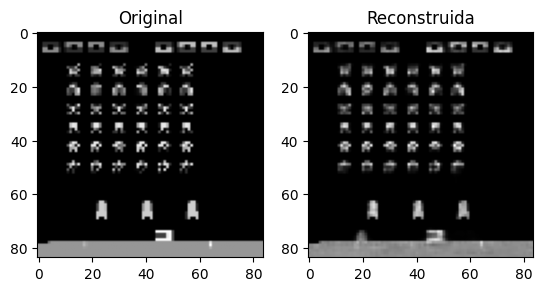

In [30]:
img = preprocessed_images[3]  # por ejemplo
img = tf.expand_dims(img, axis=0)  # (1, 84, 84, 1)
z_mean, z_log_var, z = encoder(img)
recon = decoder(z)  # Usa el vector latente como entrada

import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.imshow(tf.squeeze(img), cmap="gray")
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(tf.squeeze(recon), cmap="gray")
plt.title("Reconstruida")

plt.show()

# 3. Implementación VAE V2

## 3.1 Inicialización entorno

In [ ]:
class FrameAverageWrapper(gym.Wrapper):
  def __init__(self, env, num_frames=4):
    super(FrameAverageWrapper, self).__init__(env)
    self.num_frames = num_frames
    self.frames = []

  def reset(self):
    obs = self._preprocess_observation(self.env.reset())
    self.frames = [obs] * self.num_frames
    return self._get_average_frame()

  def step(self, action):
    obs, reward, done, info = self.env.step(action)
    self.frames.append(self._preprocess_observation(obs))
    if len(self.frames) > self.num_frames:
      self.frames.pop(0)
    return self._get_average_frame(), reward, done, info

  def _get_average_frame(self):
    return np.mean(np.array(self.frames), axis=0).astype(np.uint8)

  def _crop_observation(self, obs):
    return obs[25:195]

  def _change_colors(self, obs, original_color, target_color):
    mask = np.all(obs == original_color, axis=-1)
    obs[mask] = target_color
    return obs

  def _remove_number_observation(self, obs):
    return self._change_colors(obs, [162, 134, 56], [0, 0, 0])

  def _change_bullet_color(self, obs):
    return self._change_colors(obs, [142, 142, 142], [255, 255, 255])

  def _preprocess_observation(self, obs):
    obs = self._crop_observation(obs)
    obs = self._remove_number_observation(obs)
    obs = self._change_bullet_color(obs)
    return obs

In [ ]:
INPUT_SHAPE = (84, 84)
WINDOW_LENGTH = 4

env_name = 'SpaceInvaders-v0'
env = gym.make(env_name)

np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

env = FrameAverageWrapper(env, 4)

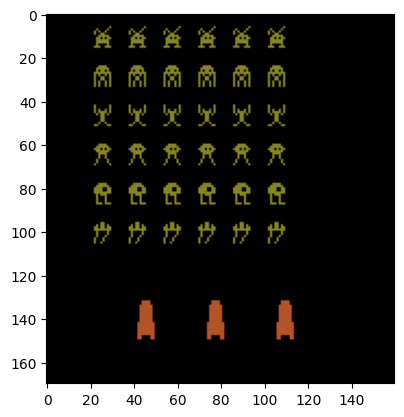

In [ ]:
# Iniciar simulación
obs = env.reset()
plt.imshow(obs)
plt.show()

## 3.2 Generar observaciones


In [ ]:
obs = env.reset()
done = False

tipo_accion = [
    np.random.randint(nb_actions, size=5000),
    np.concatenate((np.full((45), 2, dtype=int), np.random.randint(nb_actions, size=5000)), axis=0),
    np.concatenate((np.full((50), 2, dtype=int), np.random.randint(nb_actions, size=5000)), axis=0),
    np.concatenate((np.full((55), 2, dtype=int), np.random.randint(nb_actions, size=5000)), axis=0),
    np.concatenate((np.full((60), 2, dtype=int), np.random.randint(nb_actions, size=5000)), axis=0),
    np.concatenate((np.full((65), 2, dtype=int), np.random.randint(nb_actions, size=5000)), axis=0),
    np.concatenate((np.full((70), 2, dtype=int), np.random.randint(nb_actions, size=5000)), axis=0),
    np.concatenate((np.full((75), 2, dtype=int), np.random.randint(nb_actions, size=5000)), axis=0),
    np.concatenate((np.full((80), 2, dtype=int), np.random.randint(nb_actions, size=5000)), axis=0),
    np.concatenate((np.full((85), 2, dtype=int), np.random.randint(nb_actions, size=5000)), axis=0),
    np.concatenate((np.full((90), 2, dtype=int), np.random.randint(nb_actions, size=5000)), axis=0),
    np.concatenate((np.full((95), 2, dtype=int), np.random.randint(nb_actions, size=5000)), axis=0),
    np.concatenate((np.full((100), 2, dtype=int), np.random.randint(nb_actions, size=5000)), axis=0)
]

lista_obs = []

for tipo in tipo_accion:
  for accion in tipo:
    new_obs, reward, done, info = env.step(accion)

    lista_obs.append(new_obs)

    if done == True:
      obs = env.reset()
      break

In [ ]:
print('Observation list size:', len(lista_obs))

Observation list size: 8236


### 3.2.1 Generar video

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

img = [] # some array of images
frames = [] # for storing the generated images
fig = plt.figure()
plt.axis('off')
for i in range(len(lista_obs)):
    frames.append([plt.imshow(lista_obs[i], cmap=cm.Greys_r,animated=True)])

ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=1000)
ani.save('movie.mp4')

## 3.3 Generar dataset

In [ ]:
def preprocess_img(images):
  images = images.astype('float32') / 255

  images = tf.image.rgb_to_grayscale(images)

  images = tf.image.resize(images, [84, 84])

  return images

preprocessed_images = preprocess_img(np.array(lista_obs))

print(preprocessed_images.shape)

(8236, 84, 84, 1)


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(preprocessed_images)
dataset = dataset.shuffle(buffer_size = 1000).batch(64).prefetch(tf.data.AUTOTUNE)

total_size = len(lista_obs)
val_size = int(0.2 * total_size)
train_size = total_size - val_size



train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

## 3.4 Definición modelo

In [ ]:
LATENT_DIM = 32

encoder_inputs = layers.Input(shape=(84, 84, 1))

def encorder_conv_block(n_layers, n_filters, kernel, last_layer):

  x = last_layer
  for i in range(n_layers):
    x = layers.Conv2D(n_filters, kernel, padding='same', activation='relu')(x)

  x = layers.MaxPooling2D((2, 2))(x)

  return x

def sampling(args):
  z_mean, z_log_var = args
  eps = tf.random.normal(shape=(tf.shape(z_mean)[0], LATENT_DIM))
  return z_mean + tf.exp(0.5 * z_log_var) * eps

def decoder_conv_block(n_layers, n_filters, kernel, last_layer):

  x = layers.UpSampling2D(size=(2, 2))(last_layer)
  for i in range(n_layers):
    x = layers.Conv2D(n_filters, kernel, padding='same', activation='relu')(x)

  return x

In [ ]:
def build_encoder():
  inputs = encoder_inputs

  x = encorder_conv_block(1, 32, 3, inputs)
  x = encorder_conv_block(1, 64, 3, x)
  x = encorder_conv_block(1, 128, 3, x)

  x = layers.Flatten()(x)
  x = layers.Dense(128, activation='relu')(x)

  z_mean = layers.Dense(LATENT_DIM)(x)
  z_log_var = layers.Dense(LATENT_DIM)(x)

  z = layers.Lambda(sampling)([z_mean, z_log_var])

  return Model(inputs, [z_mean, z_log_var, z], name="encoder")

In [ ]:
def build_decoder():
  latent_inputs = layers.Input(shape=(LATENT_DIM,))

  x = layers.Dense(10 * 10 * 128, activation='relu')(latent_inputs)
  x = layers.Reshape((10, 10, 128))(x)

  x = decoder_conv_block(1, 64, 3, x)
  x = decoder_conv_block(1, 32, 3, x)
  x = decoder_conv_block(1, 16, 3, x)

  x = layers.Resizing(84, 84)(x)

  output = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

  return Model(latent_inputs, output, name='decoder')

In [ ]:
class VAE(Model):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

    self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
    self.val_total_loss = tf.keras.metrics.Mean(name="val_loss")

  def train_step(self, data):
    x = data  # data = batch de imágenes
    with tf.GradientTape() as tape:
      z_mean, z_log_var, z = self.encoder(x)
      x_recon = self.decoder(z)

      # Pérdida de reconstrucción
      recon_loss = tf.reduce_sum(
        tf.keras.losses.binary_crossentropy(x, x_recon), axis=(1, 2)
      )

      # KL Divergence
      kl_loss = -0.5 * tf.reduce_sum(
        1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
      )

      total_loss = tf.reduce_mean(recon_loss + kl_loss)

    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    self.total_loss_tracker.update_state(total_loss)
    return {"loss": self.total_loss_tracker.result()}

  def test_step(self, data):
    x = data
    z_mean, z_log_var, z = self.encoder(x)
    x_recon = self.decoder(z)

    recon_loss = tf.reduce_sum(
      tf.keras.losses.binary_crossentropy(x, x_recon), axis=(1, 2)
    )
    kl_loss = -0.5 * tf.reduce_sum(
        1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
    )
    total_loss = tf.reduce_mean(recon_loss + kl_loss)

    self.val_total_loss.update_state(total_loss)

    return {"val_loss": self.val_total_loss.result()}

  @property
  def metrics(self):
    return [
      self.total_loss_tracker,
      self.val_total_loss
    ]

In [ ]:
# Construir y compilar
encoder = build_encoder()
decoder = build_decoder()
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')

## 3.4 Entrenamiento

In [ ]:
# Entrenamiento
vae.fit(train_dataset, epochs=15, validation_data=val_dataset)

Epoch 1/15
129/129 [==============================] - 318s 2s/step - loss: 857.3191
Epoch 2/15
129/129 [==============================] - 317s 2s/step - loss: 645.5251
Epoch 3/15
129/129 [==============================] - 314s 2s/step - loss: 584.4854
Epoch 4/15
129/129 [==============================] - 319s 2s/step - loss: 557.6584
Epoch 5/15
129/129 [==============================] - 313s 2s/step - loss: 518.8782
Epoch 6/15
129/129 [==============================] - 312s 2s/step - loss: 487.4759
Epoch 7/15
129/129 [==============================] - 311s 2s/step - loss: 474.2843
Epoch 8/15
129/129 [==============================] - 309s 2s/step - loss: 463.7367
Epoch 9/15
129/129 [==============================] - 308s 2s/step - loss: 455.9241
Epoch 10/15
129/129 [==============================] - 312s 2s/step - loss: 449.8986
Epoch 11/15
129/129 [==============================] - 310s 2s/step - loss: 445.4447
Epoch 12/15
129/129 [==============================] - 307s 2s/step - loss

### 3.4.1 Guardar modelos

In [ ]:
encoder.save("encoder_v2.h5")
encoder.save_weights("encoder_weights_v2.h5")
decoder.save("decoder_v2.h5")
decoder.save_weights("decoder_weights_v2.h5")
vae.save_weights("vae_weights_v2.h5")

## 3.5 Pruebas

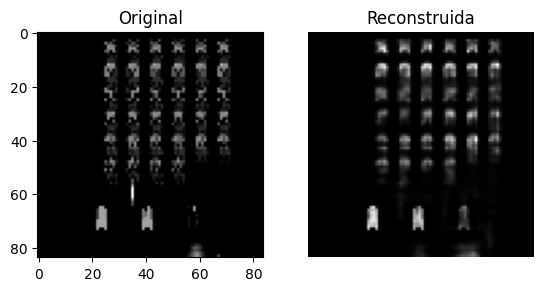

In [ ]:
img = preprocessed_images[np.random.randint(len(lista_obs))]  # por ejemplo
img = tf.expand_dims(img, axis=0)  # (1, 84, 84, 1)
z_mean, z_log_var, z = encoder(img)
recon = decoder(z)  # Usa el vector latente como entrada

import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.imshow(tf.squeeze(img), cmap="gray")
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(tf.squeeze(recon), cmap="gray")
plt.title("Reconstruida")

plt.axis('off')
plt.show()